# Network Interpretability of Lung X-rays

In this tutorial, we demonstrate visualizing network interpretability through a classification task. We will make use of [MONAI](https://monai.io/), a PyTorch-based deep learning framework for medical imaging. Specifically, we'll adapt of one of the existing [tutorials](https://github.com/Project-MONAI/tutorials) and show how the [xaitk-saliency](https://github.com/XAITK/xaitk-saliency) package can complement the current interpretability functionality in `MONAI`.

The data are a set of X-rays collated from a variety of sources. The labels used are:
- normal (the absence of the following classes)
- pneumonia
- covid

Using the `MONAI` package, we will demo the use of GradCam and occlusion sensitivity to interpret the trained network's classification choices. Using the xaitk-saliency package, we will demo the use of occlusion sensitivity with both sliding window and randomized input sampling ([RISE](https://cs-people.bu.edu/vpetsiuk/rise/)) perturbation.

### Table of Contents
* [Set Up Environment](#Set-Up-Environment-covid)
* [Download Data](#Download-Data-covid)
* [Load Images](#Load-Images-covid)
* [Training](#Training-covid)
* [Interpretability Using MONAI](#Interpretability-Using-MONAI)
* [Interpretability Using xaitk-saliency](#Interpretability-Using-xaitk-saliency)

<br>

To run this notebook in Colab, use the link below:

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/XAITK/xaitk-saliency/blob/master/examples/covid_classification.ipynb)

# Set Up Environment <a name="Set-Up-Environment-covid"></a>

In [1]:
!pip install -qU pip
!pip install -q "monai==0.6.0"
!pip install -q "xaitk-saliency"

In [2]:
import os
from glob import glob
from enum import Enum
import numpy as np
import torch
import random
import matplotlib.pyplot as plt
from sklearn.metrics import (
    classification_report, confusion_matrix,
    ConfusionMatrixDisplay
)

import monai
from monai.data import decollate_batch
from monai.networks.utils import eval_mode
from monai.networks.nets import DenseNet121
from monai.transforms import (
    Activations, AsDiscrete,
    Compose, LoadImage, Lambda, AddChannel,
    ScaleIntensity, EnsureType, RandRotate,
    RandFlip, Rand2DElastic, RandZoom, Resize,
)
from monai.apps import download_and_extract

monai.config.print_config()
monai.utils.set_determinism()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

MONAI version: 0.6.0
Numpy version: 1.21.1
Pytorch version: 1.9.0+cu102
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 0ad9e73639e30f4f1af5a1f4a45da9cb09930179

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: NOT INSTALLED or UNKNOWN VERSION.
scikit-image version: 0.18.2
Pillow version: 8.3.1
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.10.0+cu102
ITK version: NOT INSTALLED or UNKNOWN VERSION.
tqdm version: 4.62.3
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: NOT INSTALLED or UNKNOWN VERSION.
pandas version: 1.3.4
einops version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



# Download Data <a name="Download-Data-covid"></a>

The data is currently hosted on [Kaggle](https://www.kaggle.com/ericspod/project-monai-2020-bootcamp-challenge-dataset) and [Zenodo](https://zenodo.org/record/4621066). Here, we'll download the data from Zenodo. For simplicity, we'll only use the images in the training folder.

In [3]:
root_dir = 'data/monai-example'

train_url = "https://zenodo.org/record/4621066/files/training_data.zip?download=1"
train_md5 = "3e8d3e6ca43903ead0666eb6ec8849d8"
train_zip = os.path.join(root_dir, "covid_train.zip")
train_dir = os.path.join(root_dir, "covid")
download_and_extract(train_url, train_zip, train_dir, train_md5)

covid_train.zip: 341MB [00:58, 6.15MB/s]                                                                                                                                                                                                                                        


Downloaded: data/monai-example/covid_train.zip
Verified 'covid_train.zip', md5: 3e8d3e6ca43903ead0666eb6ec8849d8.
Writing into directory: data/monai-example/covid.


# Load Images <a name="Load-Images-covid"></a>

In [4]:
crop_size = (320, 320)  # set size of images for network


class Diagnosis(Enum):
    normal = 0
    pneumonia = 1
    covid = 2


num_class = len(Diagnosis)


def get_label(path):
    fname = os.path.basename(path)
    if fname[:6] == "normal":
        return Diagnosis.normal.value
    elif fname[:9] == "pneumonia":
        return Diagnosis.pneumonia.value
    elif fname[:5] == "covid":
        return Diagnosis.covid.value
    else:
        raise RuntimeError(f"Unknown label: {path}")


class CovidImageDataset(torch.utils.data.Dataset):
    def __init__(self, files, transforms, even_balance=True):

        self.image_files = files
        self.labels = list(map(get_label, self.image_files))
        self.transforms = transforms
        # For even balance, find out which diagnosis has the fewest images
        # and then get that many of each diagnosis
        if even_balance:
            # fewest images of any diagnosis
            num_to_keep = min(self.labels.count(i.value) for i in Diagnosis)
            print(f"num to keep per class: {num_to_keep}")
            self.image_files = []
            for d in Diagnosis:
                files_for_diagnosis = \
                    [file for file in files if get_label(file) == d.value]
                self.image_files += files_for_diagnosis[:num_to_keep]
            random.shuffle(self.image_files)
            self.labels = list(map(get_label, self.image_files))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        return self.transforms(self.image_files[index]), self.labels[index]


train_transforms = Compose([
    LoadImage(image_only=True),
    Lambda(lambda im: im if im.ndim == 2 else im[..., 0]),
    AddChannel(),
    Resize(spatial_size=crop_size, mode="area"),
    ScaleIntensity(),

    RandRotate(range_x=15, prob=0.5, keep_size=True),
    RandFlip(spatial_axis=0, prob=0.5),
    Rand2DElastic((0.3, 0.3), (1.0, 2.0)),
    RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5),
    EnsureType(),
])

val_transforms = Compose([
    LoadImage(image_only=True),
    Lambda(lambda im: im if im.ndim == 2 else im[..., 0]),
    AddChannel(),
    Resize(spatial_size=crop_size, mode="area"),
    ScaleIntensity(),
    EnsureType(),
])

y_pred_trans = Compose([EnsureType(), Activations(softmax=True)])
y_trans = Compose([EnsureType(), AsDiscrete(to_onehot=True, n_classes=num_class)])

all_files = glob(os.path.join(train_dir, "*.png"))
random.shuffle(all_files)
train_frac = 0.9
num_training_files = round(train_frac * len(all_files))
train_files = all_files[:num_training_files]
val_files = all_files[num_training_files:]

batch_size = 10

train_ds = CovidImageDataset(train_files, train_transforms, False)
train_loader = torch.utils.data.DataLoader(
    train_ds, batch_size=batch_size, shuffle=True, num_workers=10)

val_ds = CovidImageDataset(val_files, val_transforms, False)
val_loader = torch.utils.data.DataLoader(
    val_ds, batch_size=batch_size, shuffle=True, num_workers=10)

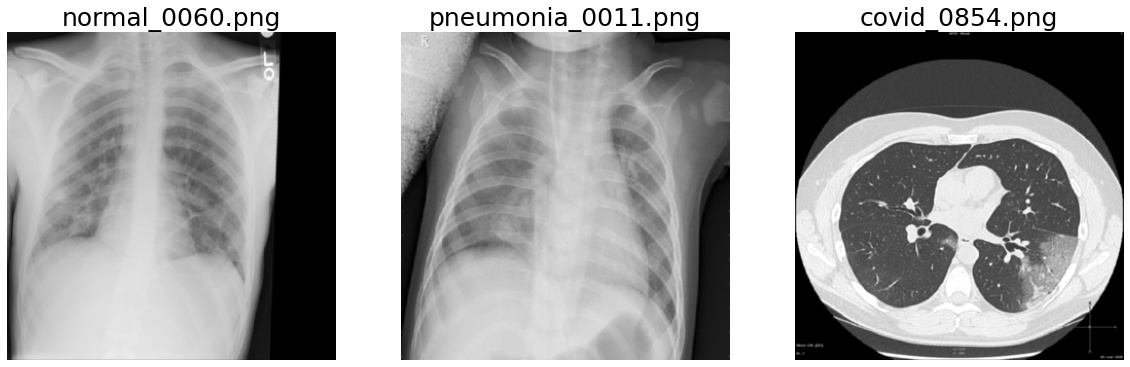

In [5]:
# Use JPEG format for inline visualizations here.
%config InlineBackend.figure_format = "jpeg"

# Display examples
fig, axes = plt.subplots(1, 3, figsize=(20, 12), facecolor='white')
for true_label in Diagnosis:
    fnames = [v for v in val_files if true_label.name in os.path.basename(v)]
    random.shuffle(fnames)
    fname = fnames[0]
    im = val_transforms(fname)
    ax = axes[true_label.value]
    im_show = ax.imshow(im[0], cmap='gray')
    ax.set_title(os.path.basename(fname), fontsize=25)
    ax.axis('off')

# Training <a name="Training-covid"></a>

In [6]:
def create_new_net():
    return DenseNet121(
        spatial_dims=2,
        in_channels=1,
        out_channels=num_class
    ).to(device)

<IPython.core.display.Javascript object>


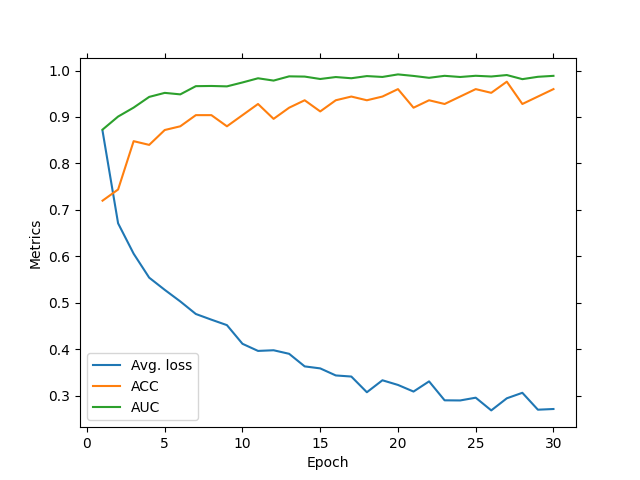

/home/brian/.cache/pypoetry/virtualenvs/xaitk-saliency-BlgCxOoJ-py3.7/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


<IPython.core.display.Javascript object>


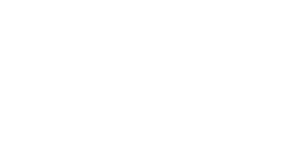

In [7]:
%matplotlib notebook

max_epochs = 30
val_interval = 1
lr = 1e-5
epoch_loss_values = []
auc = []
acc = []
best_acc = -1

net = create_new_net()
loss = torch.nn.CrossEntropyLoss()
opt = torch.optim.Adam(net.parameters(), lr)
auc_metric = monai.metrics.ROCAUCMetric()

# Plotting stuff
fig, ax = plt.subplots(1, 1, facecolor='white')
ax.set_xlabel('Epoch')
ax.set_ylabel('Metrics')
plt.ion()
fig.show()
fig.canvas.draw()

for epoch in range(max_epochs):
    net.train()
    epoch_loss = 0

    for batch_data in train_loader:

        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        opt.zero_grad()
        outputs = net(inputs)
        lossval = loss(outputs, labels)
        lossval.backward()
        opt.step()

        epoch_loss += lossval.item()

    epoch_loss /= len(train_loader)
    epoch_loss_values.append(epoch_loss)

    if (epoch + 1) % val_interval == 0:
        with eval_mode(net):
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)

            for val_data in val_loader:
                val_images, val_labels = val_data[0].to(
                    device), val_data[1].to(device),

                outputs = net(val_images)
                y_pred = torch.cat([y_pred, outputs], dim=0)
                y = torch.cat([y, val_labels], dim=0)

            y_onehot = [y_trans(i) for i in decollate_batch(y)]
            y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
            auc_metric(y_pred_act, y_onehot)
            del y_pred_act, y_onehot
            auc_result = auc_metric.aggregate()
            auc_metric.reset()
            auc.append(auc_result)

            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            acc.append(acc_metric)

            if acc_metric > best_acc:
                best_acc = acc_metric
                torch.save(net.state_dict(),
                           os.path.join(root_dir, "best_acc_covid_tutorial.pth"))

    ax.clear()
    train_epochs = np.linspace(1, epoch + 1, epoch + 1)
    ax.plot(train_epochs, epoch_loss_values, label='Avg. loss')
    val_epochs = np.linspace(
        1, epoch + 1, np.floor(
            (epoch + 1) / val_interval).astype(np.int32))
    ax.plot(val_epochs, acc, label='ACC')
    ax.plot(val_epochs, auc, label='AUC')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Metrics')
    ax.legend()
    fig.canvas.draw()

              precision    recall  f1-score   support

      normal       0.93      0.87      0.90        15
   pneumonia       1.00      0.95      0.97        20
       covid       0.98      1.00      0.99        90

    accuracy                           0.98       125
   macro avg       0.97      0.94      0.95       125
weighted avg       0.98      0.98      0.98       125



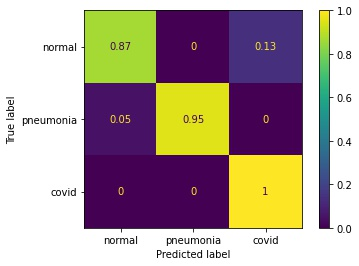

In [8]:
%matplotlib inline
# Load best model
net.load_state_dict(torch.load(os.path.join(root_dir, "best_acc_covid_tutorial.pth")))
net.to(device)
net.eval()

with eval_mode(net):
    y_pred = torch.tensor([], dtype=torch.float32, device=device)
    y = torch.tensor([], dtype=torch.long, device=device)

    for val_data in val_loader:
        val_images, val_labels = val_data[0].to(
            device), val_data[1].to(device),

        outputs = net(val_images)
        y_pred = torch.cat([y_pred, outputs.argmax(dim=1)], dim=0)
        y = torch.cat([y, val_labels], dim=0)

print(classification_report(
    y.cpu().numpy(),
    y_pred.cpu().numpy(),
    target_names=[d.name for d in Diagnosis]))

cm = confusion_matrix(
    y.cpu().numpy(),
    y_pred.cpu().numpy(),
    normalize='true',
)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=[d.name for d in Diagnosis],
)
disp.plot(ax=plt.subplots(1, 1, facecolor='white')[1])

# Interpretability Using MONAI

Use GradCAM and occlusion sensitivity for network interpretability.

The occlusion sensitivity returns two images: the sensitivity image and the most probable class.

* Sensitivity image -- how the probability of an inferred class changes as the corresponding part of the image is occluded.
    * Big decreases in the probability imply that that region was important in inferring the given class.
    * The output is the same as the input, with an extra dimension of size N appended. Here, N is the number of inferred classes. To then see the sensitivity image of the class we're interested in (maybe the true class, maybe the predcited class, maybe anything else), we simply do ``im[...,i]``.
* Most probable class -- if that part of the image is covered up, does the predicted class change, and if so, to what?

In this example, the network has been sufficiently trained that the predicted class doesn't change as parts of the image are occluded (so we don't show the most probable class maps). However, this feature might be useful when the results are less than satisfactory. 

In [9]:
# for name, _ in net.named_modules(): print(name)
target_layer = "class_layers.relu"

gradcam = monai.visualize.GradCAM(nn_module=net, target_layers=target_layer)
occ_sens = monai.visualize.OcclusionSensitivity(
    nn_module=net, mask_size=10, n_batch=batch_size, stride=10)

We can now visualize the computed saliency maps for each image.

Computing occlusion sensitivity: 100%|██████████| 1024/1024 [00:03<00:00, 337.36it/s]


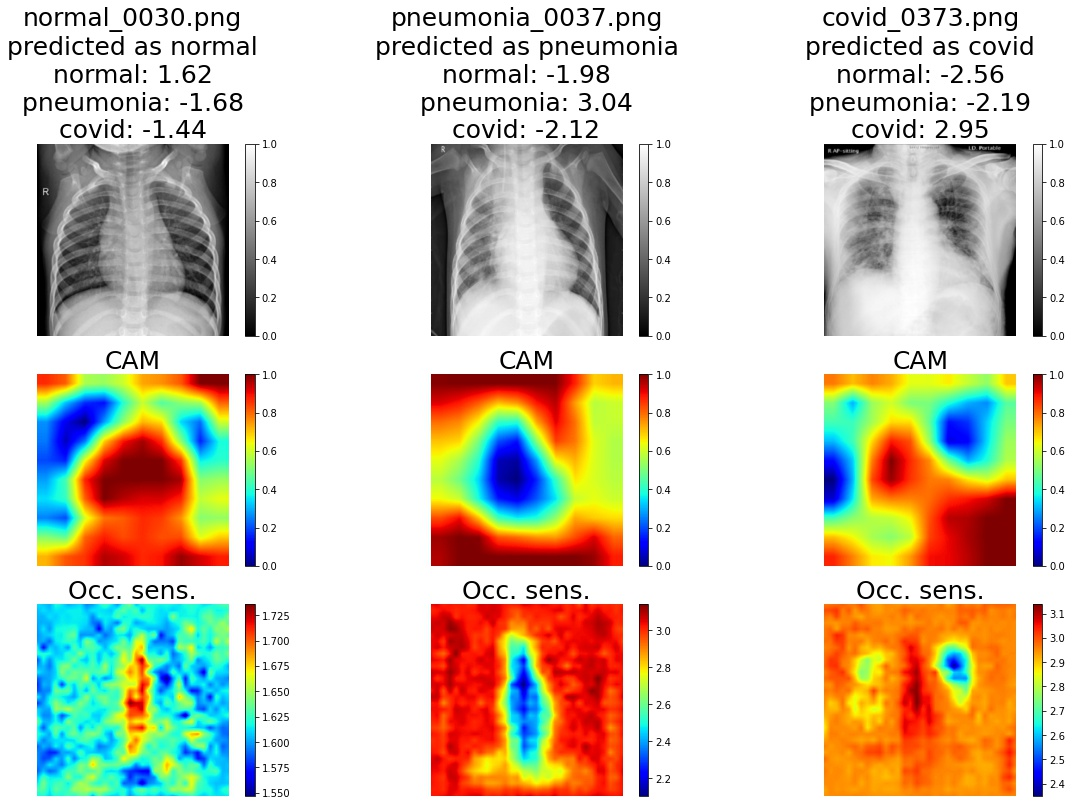

In [10]:
# Display examples
subplot_shape = [3, num_class]
fig, axes = plt.subplots(*subplot_shape, figsize=(20, 12), facecolor='white')

for true_label in Diagnosis:

    fnames = [v for v in val_files if true_label.name in os.path.basename(v)]
    random.shuffle(fnames)
    # Find a correctly predicted example
    for fname in fnames:
        img = val_transforms(fname)[None].to(device)
        y_pred = net(img)
        pred_label = Diagnosis(y_pred.argmax(1).item())
        if pred_label == true_label:
            break
    im_title = f"{os.path.basename(fname)}\npredicted as {pred_label.name}"
    for d in Diagnosis:
        im_title += f"\n{d.name}: {y_pred[0,d.value]:.3}"

    res_cam = gradcam(x=img, class_idx=true_label.value)
    occ_map, occ_most_prob = occ_sens(x=img)
    occ_map = occ_map[..., true_label.value]

    # the rest is for visualisations
    for row, (im, title) in enumerate(zip(
        [img, res_cam, occ_map],
        [im_title, "CAM", "Occ. sens."],
    )):
        cmap = 'gray' if row == 0 else 'jet'
        col = true_label.value
        ax = axes[row, col]
        if isinstance(im, torch.Tensor):
            im = im.detach().cpu()
            im_show = ax.imshow(im[0][0], cmap=cmap)

        ax.set_title(title, fontsize=25)
        ax.axis('off')
        fig.colorbar(im_show, ax=ax)

---

# Interpretability Using xaitk-saliency

Using the xaitk-saliency package, we can also compute occlusion-based saliency using either a sliding window approach (similar to the method provided by `MONAI`) or the [RISE](https://arxiv.org/abs/1806.07421) saliency algorithm. Here, we will demo the ability to switch out the saliency algorithm.

In [11]:
from smqtk_classifier import ClassifyImage
from xaitk_saliency.impls.gen_image_classifier_blackbox_sal.rise import RISEStack
from xaitk_saliency.impls.gen_image_classifier_blackbox_sal.slidingwindow import SlidingWindowStack

gen_slidingwindow = SlidingWindowStack((50, 50), (20, 20), threads=4)
gen_rise = RISEStack(1000, 8, 0.5, seed=0, threads=4, debiased=False)

We will wrap the COVID model in smqtk-classifier's `ClassifyImage` interface for standardized classifier operation with our API.

In [12]:
class COVIDModel(ClassifyImage):
    """ Blackbox model based on smqtk-classifier's ClassifyImage. """
    
    def get_labels(self):
        return list(Diagnosis.__members__)
    
    @torch.no_grad()
    def classify_images(self, image_iter):
        # Input may either be an NDaray, or some arbitrary iterable of NDarray images.
        
        for img in image_iter:
            img = val_transforms(img)[None].to(device)
            y_pred = net(img)
            # Converting feature extractor output to probabilities.
            class_conf = torch.nn.functional.softmax(y_pred, dim=1).cpu().detach().numpy().squeeze()
            # Only return the confidences for the focus classes
            yield dict(zip(self.get_labels(), class_conf))
    
    def get_config(self):
        # Required by a parent class.
        return {}

blackbox_classifier = COVIDModel()

In [13]:
# Redefine val_transforms here to be able to take in perturbed images if needed
val_transforms = Compose([
    Lambda(lambda s: LoadImage(image_only=True)(s) if isinstance(s, str) else np.array(s)),
    Lambda(lambda im: im if im.ndim == 2 else im[..., 0]),
    AddChannel(),
    Resize(spatial_size=crop_size, mode="area"),
    ScaleIntensity(),
    EnsureType(),
])

Similarly, we'll visualize the saliency maps for each image.

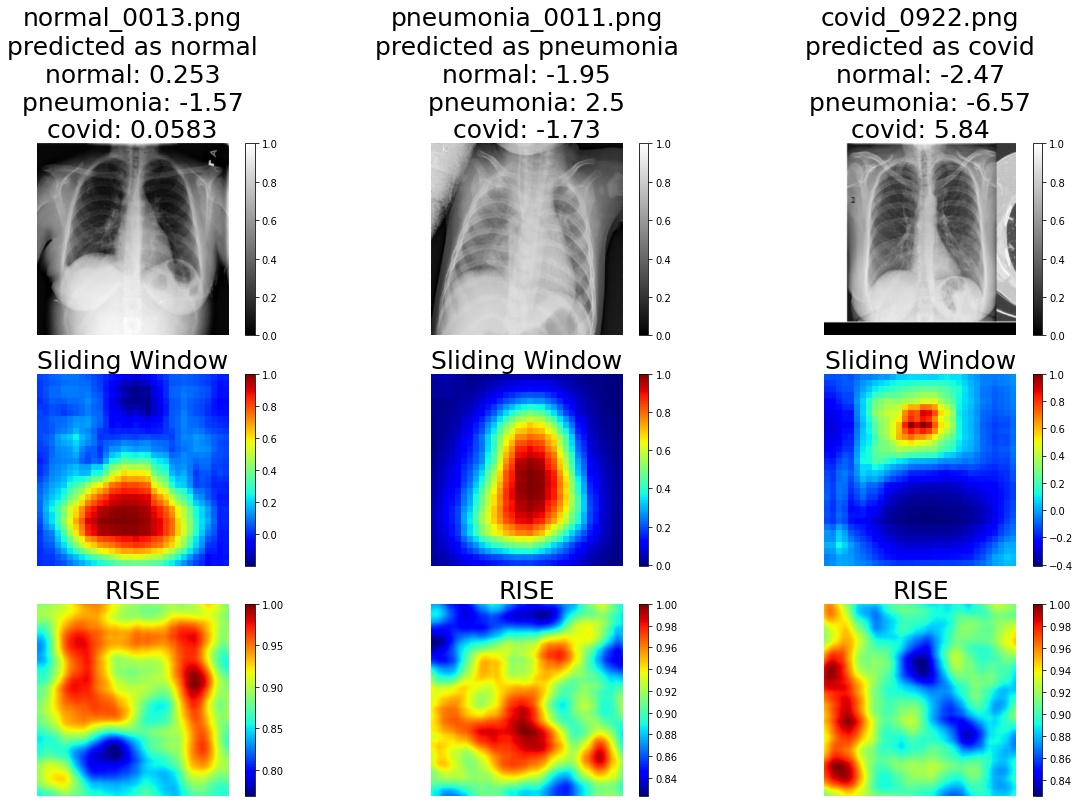

In [14]:
# Display examples
subplot_shape = [3, num_class]
fig, axes = plt.subplots(*subplot_shape, figsize=(20, 12), facecolor='white')

for true_label in Diagnosis:

    fnames = [v for v in val_files if true_label.name in os.path.basename(v)]
    random.shuffle(fnames)
    # Find a correctly predicted example
    for fname in fnames:
        img = val_transforms(fname)[None].to(device)
        y_pred = net(img)
        pred_label = Diagnosis(y_pred.argmax(1).item())
        if pred_label == true_label:
            break
    im_title = f"{os.path.basename(fname)}\npredicted as {pred_label.name}"
    for d in Diagnosis:
        im_title += f"\n{d.name}: {y_pred[0,d.value]:.3}"

    # Generate saliency maps
    ref_image = img.cpu().numpy().squeeze()
    sw_sal_map = gen_slidingwindow(ref_image, blackbox_classifier)[true_label.value]
    rise_sal_map = gen_rise(ref_image, blackbox_classifier)[true_label.value]

    # the rest is for visualisations
    for row, (im, title) in enumerate(zip(
        [img[0][0], sw_sal_map, rise_sal_map],
        [im_title, "Sliding Window", "RISE"],
    )):
        cmap = 'gray' if row == 0 else 'jet'
        col = true_label.value
        ax = axes[row, col]
        if isinstance(im, torch.Tensor):
            im = im.detach().cpu()
        im_show = ax.imshow(im, cmap=cmap)

        ax.set_title(title, fontsize=25)
        ax.axis('off')
        fig.colorbar(im_show, ax=ax)